In [2]:
import numpy as np
import h5py as h5
from matplotlib import pyplot as plt
from IPython.display import Image
import tensorflow as tf
sys.path.append('/scratch/mjosef/Unfolding/omnifold')
import omnifold_routine

Horovod not found, will continue with single only GPUs.
Horovod not found, will continue with single only GPUs.


In [3]:
from omnifold import DataLoader, MultiFold, MLP, SetStyle, HistRoutine

# OmniFold example using high-level features as inputs

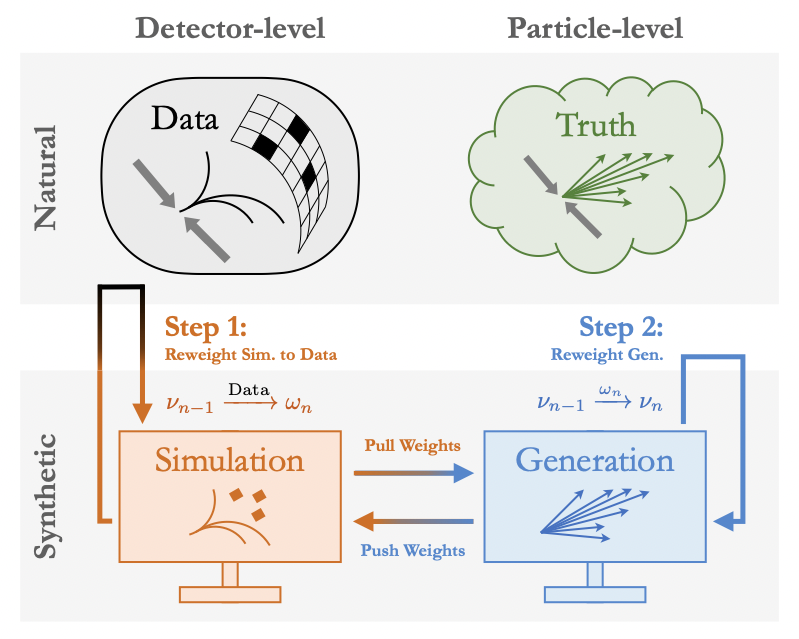

In [3]:
Image(filename='Omnifold.png')

In [4]:
def detector(x,std = 0.5):
    """ Create a fake detector response that smears the inputs given a gaussian distribution with mean 0 and std"""
    return x + np.random.normal(size=x.shape)*std

In [5]:
nevts = 1_000_000 #Number of training events we are going to use
ndim = 4 #Number of features we are going to create

In [6]:
gen_data = np.random.normal(size=(nevts,ndim),loc=ndim*[0.0],scale=ndim*[1.0])
reco_data = detector(gen_data)
gen_mc = np.random.normal(size=(nevts,ndim),loc=ndim*[1.0],scale=ndim*[1.0])
reco_mc = detector(gen_mc)

data = DataLoader(reco = reco_data,normalize=True)
mc = DataLoader(reco = reco_mc,gen = gen_mc,normalize=True)

INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Normalizing sum of weights to 1000000 ...
INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Normalizing sum of weights to 1000000 ...


## Let's take a quick look at the data

(<Figure size 900x900 with 2 Axes>,
 <Axes: ylabel='Normalized number of events'>)

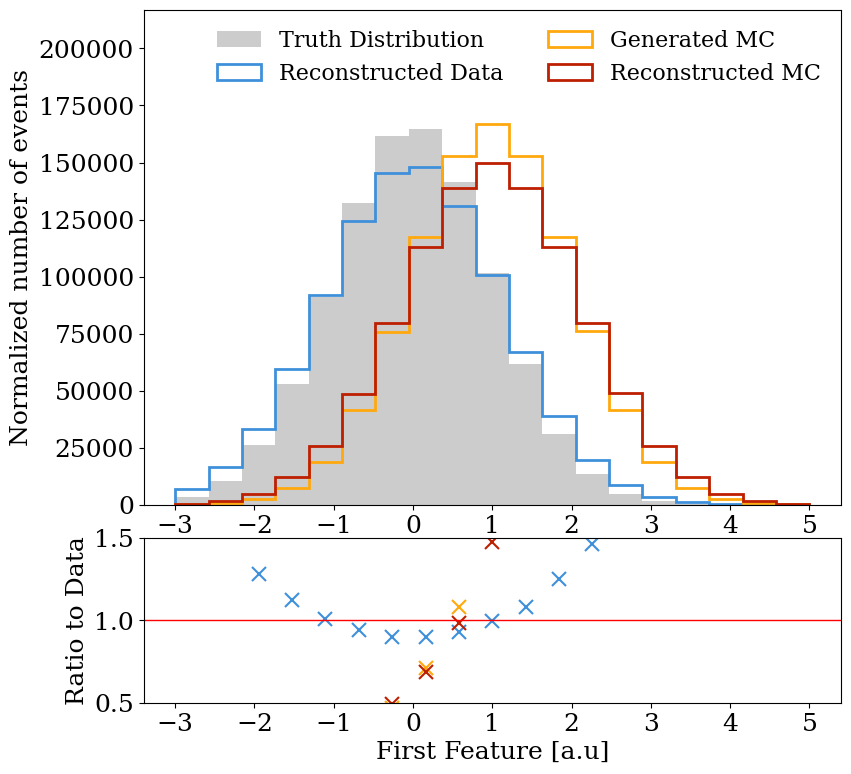

In [7]:
SetStyle()
data_dict = {
    'Truth Distribution': gen_data[:,0],
    'Reconstructed Data': reco_data[:,0],
    'Generated MC': gen_mc[:,0],
    'Reconstructed MC': reco_mc[:,0],
}
HistRoutine(data_dict,'First Feature [a.u]', reference_name = 'Truth Distribution',plot_ratio=True, binning = np.linspace(-3,5,20),)

## Let's now create the neural network models we are going to use to model the weight distributions

In [8]:
model1 = MLP(ndim)
model2 = MLP(ndim)

I0000 00:00:1764871035.227181 3101669 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 137186 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:03:00.0, compute capability: 9.0
I0000 00:00:1764871035.229794 3101669 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 140836 MB memory:  -> device: 1, name: NVIDIA H200, pci bus id: 0000:23:00.0, compute capability: 9.0
I0000 00:00:1764871035.232141 3101669 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 140836 MB memory:  -> device: 2, name: NVIDIA H200, pci bus id: 0000:43:00.0, compute capability: 9.0
I0000 00:00:1764871035.234612 3101669 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 138034 MB memory:  -> device: 3, name: NVIDIA H200, pci bus id: 0000:63:00.0, compute capability: 9.0
I0000 00:00:1764871035.236561 3101669 gpu_device.cc:2019] Created device /job:localhost/replica:0/ta

In [9]:
print(model1.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

None


## Let's now unfold!

In [10]:
omnifold = omnifold_routine.MultiFold(
    "Gaussian_test",
    model1,
    model2,
    data,
    mc,
    batch_size = 512,
    niter = 5,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = 'weights',
    verbose = True,
    lr = 5e-5,
)

3906 training steps at reco and 3906 steps at gen


In [11]:
omnifold.Unfold()

ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 1999872, Test events used: 399974
################################################################################
Epoch 1/100


I0000 00:00:1764871071.840284 3102434 service.cc:152] XLA service 0x7f6f14004410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764871071.840317 3102434 service.cc:160]   StreamExecutor device (0): NVIDIA H200, Compute Capability 9.0
I0000 00:00:1764871071.840324 3102434 service.cc:160]   StreamExecutor device (1): NVIDIA H200, Compute Capability 9.0
I0000 00:00:1764871071.840327 3102434 service.cc:160]   StreamExecutor device (2): NVIDIA H200, Compute Capability 9.0
I0000 00:00:1764871071.840329 3102434 service.cc:160]   StreamExecutor device (3): NVIDIA H200, Compute Capability 9.0
I0000 00:00:1764871071.840331 3102434 service.cc:160]   StreamExecutor device (4): NVIDIA H200, Compute Capability 9.0
I0000 00:00:1764871071.840333 3102434 service.cc:160]   StreamExecutor device (5): NVIDIA H200, Compute Capability 9.0
I0000 00:00:1764871071.840335 3102434 service.cc:160]   StreamExecutor device (6): NVIDIA H200, Compute Capability 9.

  18/3124 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.6806    

I0000 00:00:1764871072.663530 3102434 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3124/3124 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.4675 - val_loss: 0.4042 - learning_rate: 5.0000e-05
Epoch 2/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.4048 - val_loss: 0.4041 - learning_rate: 5.0000e-05
Epoch 3/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.4044 - val_loss: 0.4040 - learning_rate: 5.0000e-05
Epoch 4/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.4054 - val_loss: 0.4040 - learning_rate: 5.0000e-05
Epoch 5/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.4045 - val_loss: 0.4040 - learning_rate: 5.0000e-05
Epoch 6/100
3121/3124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4055
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.4055 - val_loss: 0.4041 - learning_rate: 5.0000e-05
Epoch 7/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.4045 - val_loss: 0.4040 - learning_rate: 5.0000e-06
Epoch 8/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/s

## Now, let's evaluate the model!

In [12]:
validation_data = np.random.normal(size=(5*nevts,ndim),loc=ndim*[1.0],scale=ndim*[1.0])
unfolded_weights  = omnifold.reweight(validation_data,omnifold.model2,batch_size=1000)   

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 4s 718us/step


In [13]:
print(unfolded_weights)

[0.15092468 0.22673859 0.06715243 ... 0.0252275  1.80507135 0.00653202]


## More plots!

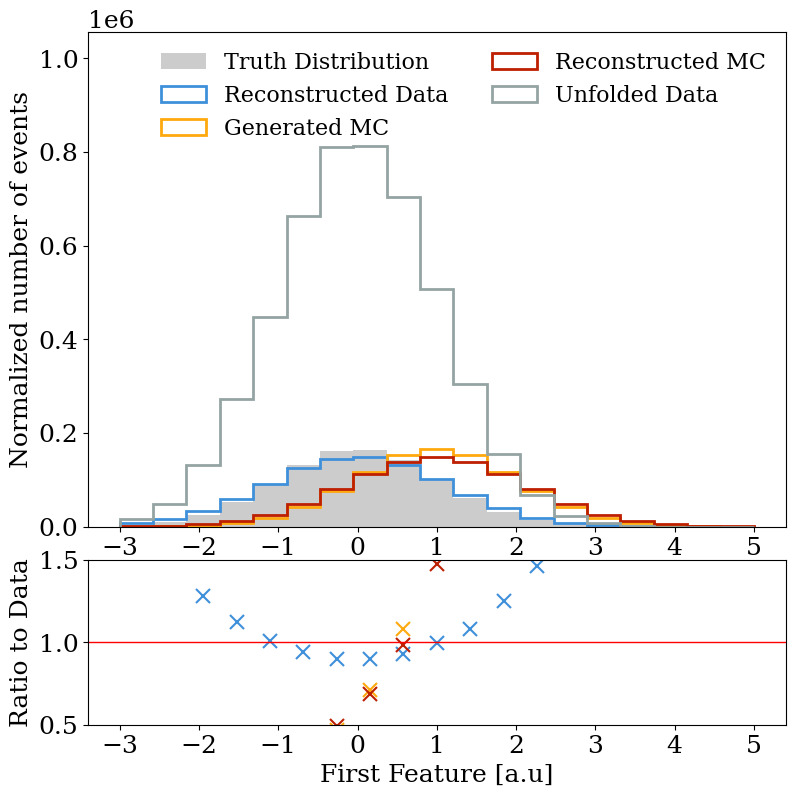

In [14]:
data_dict = {
    'Truth Distribution': gen_data[:,0],
    'Reconstructed Data': reco_data[:,0],
    'Generated MC': gen_mc[:,0],
    'Reconstructed MC': reco_mc[:,0],
    'Unfolded Data': validation_data[:,0],
}

weight_dict = {
    'Truth Distribution': data.weight,
    'Reconstructed Data': data.weight,
    'Generated MC': mc.weight,
    'Reconstructed MC': mc.weight,
    'Unfolded Data': unfolded_weights,
    }

fig,_ = HistRoutine(data_dict,'First Feature [a.u]',
                    reference_name = 'Truth Distribution',
                    weights = weight_dict,
                    plot_ratio = True,
                    binning = np.linspace(-3,5,20)
                    )
